<a href="https://colab.research.google.com/github/zeliz22/Facial-Expression/blob/main/BasicModel%2BBatchNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!  pip install kaggle
! pip install wandb
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zeliz22 (zeliz22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zazaelizbarashvili","key":"3422f18d69545d5f43297b0e7bfb79f8"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip


 89% 254M/285M [00:00<00:00, 826MB/s] 
100% 285M/285M [00:00<00:00, 853MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


Using device: cuda
Training data shape: (28709, 2)
Test data shape: (7178, 1)
Unique emotions: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Emotion distribution:
0 (Angry): 3995
1 (Disgust): 436
2 (Fear): 4097
3 (Happy): 7215
4 (Sad): 4830
5 (Surprise): 3171
6 (Neutral): 4965


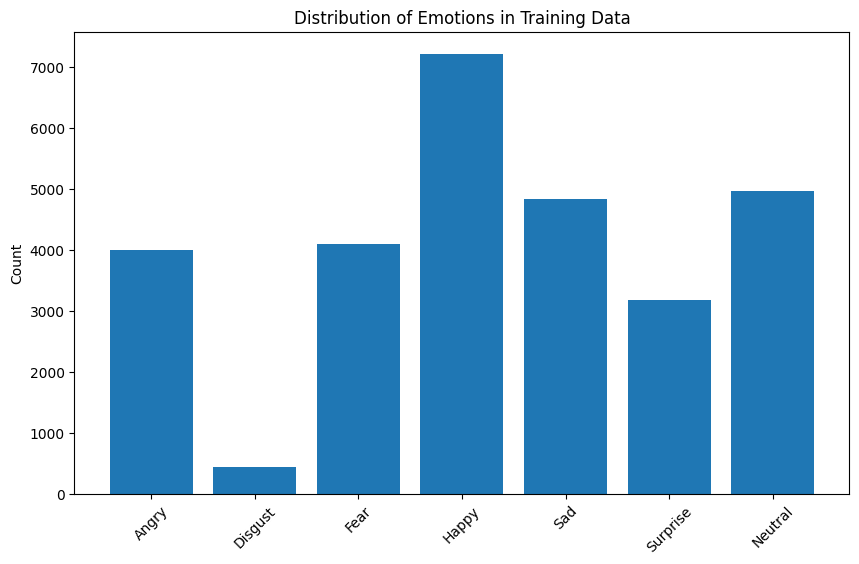

In [5]:
# Cell 1: Setup and Data Loading
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Unique emotions: {sorted(train_df['emotion'].unique())}")

# Check class distribution
emotion_counts = train_df['emotion'].value_counts().sort_index()
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print("\nEmotion distribution:")
for i, count in emotion_counts.items():
    print(f"{i} ({emotion_labels[i]}): {count}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(range(7), emotion_counts.values)
plt.xticks(range(7), emotion_labels, rotation=45)
plt.title('Distribution of Emotions in Training Data')
plt.ylabel('Count')
plt.show()

Training samples: 22967
Validation samples: 5742


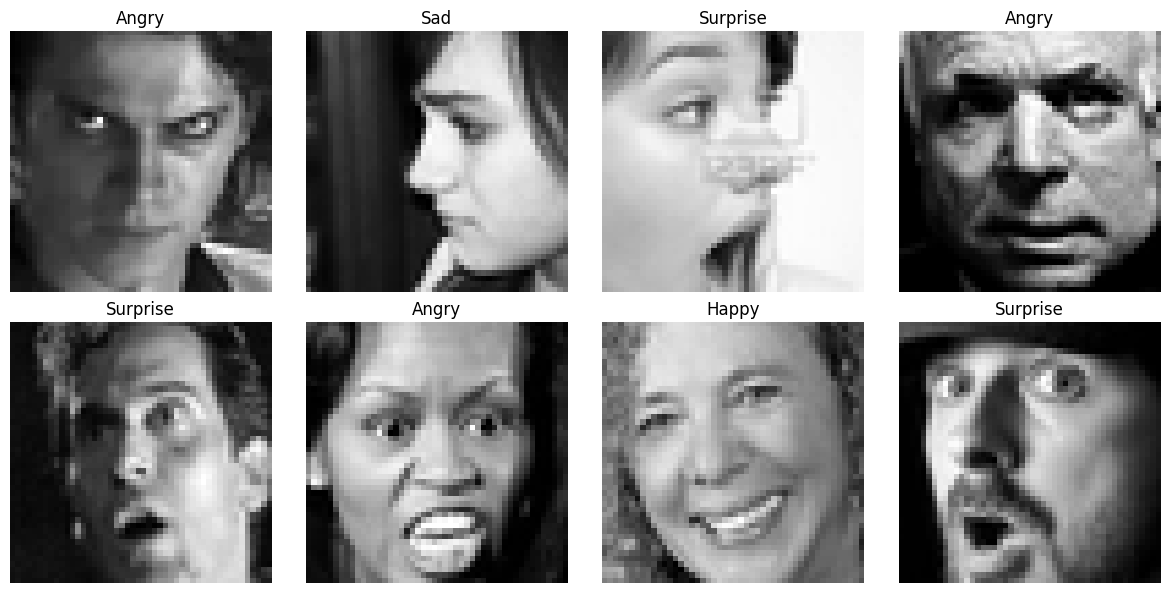

In [6]:
# Cell 2: Data Preprocessing and Dataset Class

def preprocess_pixels(pixel_string):
    """Convert pixel string to numpy array and normalize"""
    pixels = np.array(pixel_string.split(), dtype=np.float32)
    pixels = pixels.reshape(48, 48)
    # Normalize to [0, 1]
    pixels = pixels / 255.0
    return pixels

class FERDataset(Dataset):
    def __init__(self, df, is_test=False, transform=None):
        self.df = df
        self.is_test = is_test
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get pixels
        pixels = preprocess_pixels(self.df.iloc[idx]['pixels'])

        # Convert to tensor and add channel dimension
        image = torch.FloatTensor(pixels).unsqueeze(0)  # Shape: (1, 48, 48)

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image
        else:
            label = torch.LongTensor([self.df.iloc[idx]['emotion']])[0]
            return image, label

# Create train-validation split
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['emotion'])

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# Visualize some samples
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    sample_idx = np.random.randint(0, len(train_data))
    pixels = preprocess_pixels(train_data.iloc[sample_idx]['pixels'])
    emotion = train_data.iloc[sample_idx]['emotion']

    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title(f'{emotion_labels[emotion]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Create datasets
train_dataset = FERDataset(train_data.reset_index(drop=True))
val_dataset = FERDataset(val_data.reset_index(drop=True))
test_dataset = FERDataset(test_df, is_test=True)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Cell 4: Improved Model v1 - Deeper Architecture with Batch Normalization

class ImprovedCNN_v1(nn.Module):
    def __init__(self, num_classes=7):
        super(ImprovedCNN_v1, self).__init__()

        # First block
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Second block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Third block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)

        # Fourth block
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # 48x48 -> 24x24

        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)  # 24x24 -> 12x12

        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)  # 12x12 -> 6x6

        # Fourth block
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.global_pool(x)  # 6x6 -> 1x1

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x


In [14]:
# Training function with learning rate scheduler
# Training function with train accuracy and validation loss printing
def train_model_v2(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        scheduler.step()
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Acc: {val_accuracy:.2f}%, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    return train_losses, val_accuracies

# Initialize and train improved model v1
print("Training Improved CNN Model v1...")
improved_model_v1 = ImprovedCNN_v1().to(device)
print(f"Model parameters: {sum(p.numel() for p in improved_model_v1.parameters()):,}")

improved_v1_train_losses, improved_v1_val_accuracies = train_model_v2(improved_model_v1, train_loader, val_loader, num_epochs=20)

print(f"Improved v1 best validation accuracy: {max(improved_v1_val_accuracies):.2f}%")

Training Improved CNN Model v1...
Model parameters: 2,492,359


Epoch 1/20: 100%|██████████| 359/359 [00:25<00:00, 14.29it/s]


Epoch [1/20], Train Loss: 1.7133, Train Acc: 30.06%, Val Loss: 1.7024, Val Acc: 33.73%, LR: 0.001000


Epoch 2/20: 100%|██████████| 359/359 [00:25<00:00, 14.27it/s]


Epoch [2/20], Train Loss: 1.4880, Train Acc: 41.46%, Val Loss: 1.3996, Val Acc: 45.80%, LR: 0.001000


Epoch 3/20: 100%|██████████| 359/359 [00:25<00:00, 14.08it/s]


Epoch [3/20], Train Loss: 1.3775, Train Acc: 46.51%, Val Loss: 1.3942, Val Acc: 46.81%, LR: 0.001000


Epoch 4/20: 100%|██████████| 359/359 [00:25<00:00, 14.01it/s]


Epoch [4/20], Train Loss: 1.3074, Train Acc: 49.87%, Val Loss: 1.2791, Val Acc: 50.89%, LR: 0.001000


Epoch 5/20: 100%|██████████| 359/359 [00:25<00:00, 14.09it/s]


Epoch [5/20], Train Loss: 1.2406, Train Acc: 52.83%, Val Loss: 1.2188, Val Acc: 53.22%, LR: 0.001000


Epoch 6/20: 100%|██████████| 359/359 [00:25<00:00, 14.07it/s]


Epoch [6/20], Train Loss: 1.1944, Train Acc: 54.65%, Val Loss: 1.3244, Val Acc: 49.60%, LR: 0.001000


Epoch 7/20: 100%|██████████| 359/359 [00:26<00:00, 13.31it/s]


Epoch [7/20], Train Loss: 1.1421, Train Acc: 56.98%, Val Loss: 1.1666, Val Acc: 56.29%, LR: 0.000500


Epoch 8/20: 100%|██████████| 359/359 [00:25<00:00, 14.19it/s]


Epoch [8/20], Train Loss: 1.0425, Train Acc: 60.70%, Val Loss: 1.1170, Val Acc: 57.72%, LR: 0.000500


Epoch 9/20: 100%|██████████| 359/359 [00:25<00:00, 14.13it/s]


Epoch [9/20], Train Loss: 0.9854, Train Acc: 62.95%, Val Loss: 1.1543, Val Acc: 58.06%, LR: 0.000500


Epoch 10/20: 100%|██████████| 359/359 [00:25<00:00, 14.17it/s]


Epoch [10/20], Train Loss: 0.9352, Train Acc: 65.32%, Val Loss: 1.1741, Val Acc: 57.26%, LR: 0.000500


Epoch 11/20: 100%|██████████| 359/359 [00:25<00:00, 14.06it/s]


Epoch [11/20], Train Loss: 0.8730, Train Acc: 67.29%, Val Loss: 1.2440, Val Acc: 57.35%, LR: 0.000500


Epoch 12/20: 100%|██████████| 359/359 [00:25<00:00, 14.30it/s]


Epoch [12/20], Train Loss: 0.8143, Train Acc: 70.26%, Val Loss: 1.7135, Val Acc: 52.51%, LR: 0.000500


Epoch 13/20: 100%|██████████| 359/359 [00:24<00:00, 14.73it/s]


Epoch [13/20], Train Loss: 0.7514, Train Acc: 72.70%, Val Loss: 1.5804, Val Acc: 51.32%, LR: 0.000500


Epoch 14/20: 100%|██████████| 359/359 [00:24<00:00, 14.44it/s]


Epoch [14/20], Train Loss: 0.6805, Train Acc: 75.56%, Val Loss: 1.2614, Val Acc: 58.92%, LR: 0.000250


Epoch 15/20: 100%|██████████| 359/359 [00:25<00:00, 14.13it/s]


Epoch [15/20], Train Loss: 0.5188, Train Acc: 81.26%, Val Loss: 1.3923, Val Acc: 60.29%, LR: 0.000250


Epoch 16/20: 100%|██████████| 359/359 [00:25<00:00, 14.14it/s]


Epoch [16/20], Train Loss: 0.4358, Train Acc: 84.79%, Val Loss: 1.6886, Val Acc: 57.75%, LR: 0.000250


Epoch 17/20: 100%|██████████| 359/359 [00:25<00:00, 14.09it/s]


Epoch [17/20], Train Loss: 0.3717, Train Acc: 87.13%, Val Loss: 1.7629, Val Acc: 58.71%, LR: 0.000250


Epoch 18/20: 100%|██████████| 359/359 [00:25<00:00, 14.16it/s]


Epoch [18/20], Train Loss: 0.3282, Train Acc: 88.81%, Val Loss: 1.8008, Val Acc: 60.12%, LR: 0.000250


Epoch 19/20: 100%|██████████| 359/359 [00:25<00:00, 14.11it/s]


Epoch [19/20], Train Loss: 0.2848, Train Acc: 90.52%, Val Loss: 1.8812, Val Acc: 59.86%, LR: 0.000250


Epoch 20/20: 100%|██████████| 359/359 [00:25<00:00, 14.13it/s]


Epoch [20/20], Train Loss: 0.2614, Train Acc: 91.36%, Val Loss: 1.8696, Val Acc: 60.80%, LR: 0.000250
Improved v1 best validation accuracy: 60.80%


In [15]:
# Cell 8: Evaluate model on validation set
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.numpy())

    return np.array(predictions), np.array(true_labels)

# Get predictions on validation set
val_predictions, val_true = get_predictions(improved_model_v1, val_loader, device)

# Calculate accuracy
val_accuracy = accuracy_score(val_true, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
class_names = [emotion_labels[i] for i in range(7)]
print(classification_report(val_true, val_predictions, target_names=class_names))


Validation Accuracy: 0.6080

Classification Report:
              precision    recall  f1-score   support

       Angry       0.54      0.47      0.50       799
     Disgust       0.00      0.00      0.00        87
        Fear       0.47      0.46      0.47       820
       Happy       0.87      0.82      0.84      1443
         Sad       0.43      0.59      0.50       966
    Surprise       0.77      0.71      0.74       634
     Neutral       0.55      0.54      0.55       993

    accuracy                           0.61      5742
   macro avg       0.52      0.51      0.51      5742
weighted avg       0.61      0.61      0.61      5742



In [16]:
import wandb

# Start a new wandb run to track this model
run = wandb.init(
    # Set your wandb entity (replace with your username)
    entity="zeliz22-free-university-of-tbilisi-",
    # Set the wandb project
    project="Facial Expression Recognition Challenge",
    name="CNN-Base_Model + BatchNormalization",
    # Add tags to organize runs
    tags=["CNN", "facial-expression", "pytorch", "BatchNormalization"],
    # Track hyperparameters and run metadata
    config={
        "architecture": "CNN",
        "dataset": "FER2013",
        "epochs": 20,
        "image_size": "48x48",
    }
)

# Count model parameters
total_params = sum(p.numel() for p in improved_model_v1.parameters())
trainable_params = sum(p.numel() for p in improved_model_v1.parameters() if p.requires_grad)

# Log the final model results based on your training output
run.log({
    "final_train_accuracy": 0.9,  # From your results: Train Acc: 60.90%
    "final_train_loss": 0.26,     # From your results: Train Loss: 1.0504
    "final_val_accuracy": 0.6,    # From your results: Val Acc: 62.03%
    "final_val_loss": 1.8,       # From your results: Val Loss: 1.0073
    "total_parameters": total_params,
    "trainable_parameters": trainable_params,
    "steps_per_epoch": len(train_loader),  # 359 batches as shown in your output
})

# Finish the run
run.finish()

print("Model results logged to WandB successfully!")

final_train_accuracy,▁
final_train_loss,▁
final_val_accuracy,▁
final_val_loss,▁
steps_per_epoch,▁
total_parameters,▁
trainable_parameters,▁
final_train_accuracy,0.9
final_train_loss,0.26
final_val_accuracy,0.6
final_val_loss,1.8


Model results logged to WandB successfully!
